In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
import torchvision 
from torchvision import datasets, transforms,models
from sklearn.utils import shuffle

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0+cu116  Device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
NUM_CLASSES = 2

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
Number_Epochs = 50
BATCH_SIZE = 124

In [5]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

## valid transformations
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [6]:
train_dataset = '/content/drive/Mydrive/archive/casting_data/casting_data/train'  
validation_dataset = '/content/drive/Mydrive/archive/casting_data/casting_data/test'


training_dataset = datasets.ImageFolder('/content/drive/MyDrive/archive /casting_data/casting_data/train', transform=transform_train) 
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/archive /casting_data/casting_data/test', transform=transform)


###Data Loaders

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=False)




In [7]:
# Checking the dataset
print(len(train_dataset))
print(len(validation_dataset))

62
715


In [8]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in validation_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([10, 3, 224, 224])
Image label dimensions: torch.Size([10])
Image batch dimensions: torch.Size([10, 3, 224, 224])
Image label dimensions: torch.Size([10])


In [9]:
classes = ('ok_front', 'def_front')

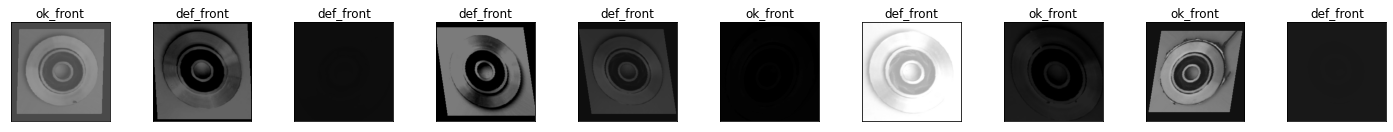

In [10]:
##### convert Tensor to image
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image


dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

Loading The Model

In [11]:
# load model with pretrained weights

from torchvision.models.vgg import vgg16

model= vgg16(pretrained=True)

print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
# change the output layer

#num_ftrs = model.classifier[0].in_features
#model.classifier[0] = nn.Linear(num_ftrs, NUM_CLASSES)
#num_ftrs = model.fc.in_features # in_features=4096
#model.fc = nn.Linear(num_ftrs, NUM_CLASSES)# (4096, 2)

#model=model.to(device) 

model.classifier[6] = nn.Sequential(nn.Linear(4096, NUM_CLASSES))

model_vgg=model.to(device)
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
# Loss Function 
criterion = nn.CrossEntropyLoss()
# Opimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [18]:
## train function 

def train(epoch, train_loss_list,train_accuracy_list, log_interval=200):
    # Set model to training mode
    model.train()
    train_loss,correct = 0,0

    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(train_loader):

        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = model(X_train)# y_dach
        
        # Zero gradient buffers: clear the gradients of all optimized variables
        optimizer.zero_grad() 

        # Calculate loss
        loss = criterion(y_predicted, y_train)# CE(y_train, y_dach)

        # Backpropagate: compute gradient of the loss with respect to model parameters
        loss.backward()# dL/dw
        
        # Update weights: perform a single optimization step (parameter update)
        optimizer.step()# w_neu= w_alt- lernrate*dL/dw_alt

      
        # save loss value in train_loss list
        train_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1]
        correct += (pred == y_train).float().sum().cpu()

        # print training statistics 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
      # calculate average loss over an epoch            
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)    
    
    accuracy = 100 * correct / len(train_loader.dataset)
    train_accuracy_list.append(accuracy)
    
    print('Train Epoch: {}\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        loss, correct, len(train_loader.dataset), accuracy))

In [19]:
## Validation function
def validate(val_loss_list,val_accuracy_list):
    model.eval()
    val_loss, correct = 0, 0
    
    for X_val, y_val in validation_loader:

        X_val = X_val.to(device)
        y_val = y_val.to(device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = model(X_val)
        
        # Calculate loss
        loss = criterion(y_predicted, y_val)
        val_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(y_val.data).cpu().sum()

    val_loss /= len(validation_loader)
    val_loss_list.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    val_accuracy_list.append(accuracy)
    
    print('Val Epoch: {}\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
######This is now the actual execution of the process
## Train model
##%%time

train_loss_values,val_loss_values, train_acc_values, val_acc_values = [], [], [], []
for epoch in range(Number_Epochs):
    train(epoch,train_loss_values, train_acc_values,)
    validate(val_loss_values, val_acc_values)

Train Epoch: 0 [0/6633 (0%)]	Loss: 0.763849
Train Epoch: 0 [2000/6633 (30%)]	Loss: 0.506106
Train Epoch: 0 [4000/6633 (60%)]	Loss: 0.565793
Train Epoch: 0 [6000/6633 (90%)]	Loss: 0.396385
Train Epoch: 0
Train set: Average loss: 0.3881, Accuracy: 4098.0/6633 (62%)

Val Epoch: 0
Validation set: Average loss: 0.5176, Accuracy: 594/715 (83%)

Train Epoch: 1 [0/6633 (0%)]	Loss: 0.562860
Train Epoch: 1 [2000/6633 (30%)]	Loss: 0.467854
Train Epoch: 1 [4000/6633 (60%)]	Loss: 0.886468
Train Epoch: 1 [6000/6633 (90%)]	Loss: 0.627217
Train Epoch: 1
Train set: Average loss: 0.0794, Accuracy: 4170.0/6633 (63%)

Val Epoch: 1
Validation set: Average loss: 0.3053, Accuracy: 512/715 (72%)

Train Epoch: 2 [0/6633 (0%)]	Loss: 0.882127
Train Epoch: 2 [2000/6633 (30%)]	Loss: 0.518375
Train Epoch: 2 [4000/6633 (60%)]	Loss: 0.608119
Train Epoch: 2 [6000/6633 (90%)]	Loss: 0.183936
Train Epoch: 2
Train set: Average loss: 0.3204, Accuracy: 4243.0/6633 (64%)

Val Epoch: 2
Validation set: Average loss: 0.4335, Ac

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(Number_Epochs), train_loss_values, 'r')
plt.plot(np.arange(Number_Epochs), val_loss_values, 'b')
plt.title('loss')
plt.legend()

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(Number_Epochs), train_acc_values, 'r')
plt.plot(np.arange(Number_Epochs),  val_acc_values, 'b')
plt.title('accuracy');
plt.legend()